In [241]:
from sklearn import linear_model
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
import cv2 as cv
import time
import math

In [236]:
#### Question-1)

# Loading point cloud binary file
bin_pcd = np.fromfile("c:/clemson_university/2nd_semester/AuE_8200_Machine_Perception_and_Intelligence/hw4/LiDAR_datasets/annotation-lidar_obstacle_label-data-apollo-1.0/bin_files/002_00000000.bin", dtype=np.float32)

# Reshaping
bin_pcd_reshaped = bin_pcd.reshape((-1, 4))
color = np.zeros([len(bin_pcd_reshaped),3])
color[:,0] = abs(np.multiply(bin_pcd_reshaped[:,0], bin_pcd_reshaped[:,3])/255)
color[:,1] = abs(np.multiply(bin_pcd_reshaped[:,1], bin_pcd_reshaped[:,3])/255)
color[:,2] = abs(np.multiply(bin_pcd_reshaped[:,2], bin_pcd_reshaped[:,3])/255)

o3d_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(bin_pcd_reshaped[:,:3]))
o3d_pcd.colors = o3d.utility.Vector3dVector(color)
o3d.io.write_point_cloud("sample101.pcd", o3d_pcd) #Saving the pointcloud 
o3d.visualization.draw_geometries([o3d_pcd])

94989


In [225]:
#### Question-2)

pcd = o3d.io.read_point_cloud("sample101.pcd") #Loading the pointcloud
voxel_pcd = pcd.voxel_down_sample(voxel_size=0.2) #Implementing voxel filter
o3d.io.write_point_cloud("sample101_voxel.pcd", voxel_pcd) #Saving the voxel pointcloud
o3d.visualization.draw_geometries([downpcd],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])


In [226]:
#### Question-3)

pcd = o3d.io.read_point_cloud("sample101_voxel.pcd")
plane_model, inliers = pcd.segment_plane(distance_threshold=0.5,
                                         ransac_n=10,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0") #Printing the equation of the plane

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1, 0, 0]) #Colorizing inliner points to 'red' 
outlier_cloud = pcd.select_by_index(inliers, invert=True)
outlier_cloud.paint_uniform_color([0, 1, 0]) #Colorizing inliner points to 'green'

#Visualizing ground plane model in 3D
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.8,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

#Visualizing all the off-ground points in 3D
o3d.visualization.draw_geometries([outlier_cloud],
                                  zoom=0.8,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

Plane equation: 0.03x + 0.01y + 1.00z + 1.44 = 0


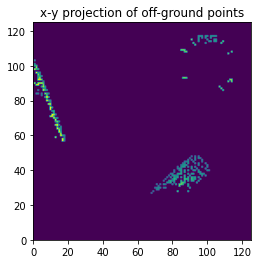

In [234]:
#### Question-4)

#Converting outlier point cloud data to -->> numpy array 
outlier_points = np.asarray(outlier_cloud.points)

x_points = outlier_points[:, 0]
y_points = outlier_points[:, 1]
z_points = outlier_points[:, 2]

fwd_range = (-10., 10.)
side_range=(-10., 10.)
res=0.1
height_range=(-2., 2.)

# Filter to return only indices of points within desired cube
f_filt = np.logical_and((x_points > fwd_range[0]), (x_points < fwd_range[1]))
s_filt = np.logical_and((y_points > -side_range[1]), (y_points < -side_range[0]))
filter = np.logical_and(f_filt, s_filt)
indices = np.argwhere(filter).flatten()

x_points = x_points[indices]
y_points = y_points[indices]
z_points = z_points[indices]

# Coverting to pixel position values on the basis of resolution
x_img = (-y_points / res).astype(np.int32)  #x-axis is -y in LIDAR
y_img = (-x_points / res).astype(np.int32)  #y-axis is -x in LIDAR

x_img -= int(np.floor(side_range[0] / res))
y_img += int(np.ceil(fwd_range[1] / res))

pixel_values = np.clip(a=z_points,
                       a_min=height_range[0],
                       a_max=height_range[1])

pixel_values = (((pixel_values - height_range[0]) / float(height_range[1] - height_range[0])) * 255).astype(dtype="float32")
                                                                                                        
x_max = 1 + int((side_range[1] - side_range[0]) / res)
y_max = 1 + int((fwd_range[1] - fwd_range[0]) / res)
im = np.zeros([y_max, x_max], dtype=np.uint8)

# Populating image array with pixel values
im[y_img, x_img] = pixel_values

#Visualizing the result
plt.imshow(im)
plt.title("x-y projection of off-ground points")
plt.xlim(0, 125)
plt.ylim(0, 125)
plt.show()

In [288]:
#### Question-5) a)

theta = []
phi = []
r = []

#Calculating r, theta and phi values
for k in range(0, len(bin_pcd_reshaped)):
    r.append(np.sqrt(bin_pcd_reshaped[k,0]**2 + bin_pcd_reshaped[k,2]**2 + bin_pcd_reshaped[k,2]**2))
    theta.append(np.arctan(bin_pcd_reshaped[k,1]/bin_pcd_reshaped[k,0]))
    phi.append(math.asin(bin_pcd_reshaped[k,2]/r[k]))

X = r * np.sin(phi) * np.cos(phi)
Y = r * np.sin(phi) * np.sin(phi)
Z = r * np.cos(phi)

a = np.zeros(shape=(len(X),3))

a[:,0] = X
a[:,1] = Y
a[:,2] = Z

o3d_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(a[:,:3]))
o3d.io.write_point_cloud("sample101.pcd", o3d_pcd) #Saving the pointcloud 
o3d.visualization.draw_geometries([o3d_pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


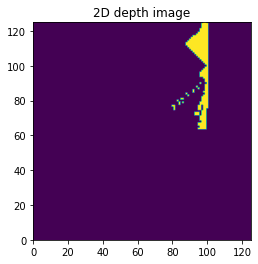

In [294]:
#### Question-5) b)

x_points = a[:, 0]
y_points = a[:, 1]
z_points = a[:, 2]

fwd_range = (-10., 10.)
side_range=(-10., 10.)
res=0.1
height_range=(-2., 2.)

# Filter to return only indices of points within desired cube
f_filt = np.logical_and((x_points > fwd_range[0]), (x_points < fwd_range[1]))
s_filt = np.logical_and((y_points > -side_range[1]), (y_points < -side_range[0]))
filter = np.logical_and(f_filt, s_filt)
indices = np.argwhere(filter).flatten()

x_points = x_points[indices]
y_points = y_points[indices]
z_points = z_points[indices]

# Coverting to pixel position values on the basis of resolution
x_img = (-y_points / res).astype(np.int32)  #x-axis is -y in LIDAR
y_img = (-x_points / res).astype(np.int32)  #y-axis is -x in LIDAR

x_img -= int(np.floor(side_range[0] / res))
y_img += int(np.ceil(fwd_range[1] / res))

pixel_values = np.clip(a=bin_pcd_reshaped[:,3], #Distance as intentisy values from the pointcloud data
                       a_min=height_range[0],
                       a_max=height_range[1])

pixel_values = (((pixel_values - height_range[0]) / float(height_range[1] - height_range[0])) * 255).astype(dtype="float32")
                                                                                                        
x_max = 1 + int((side_range[1] - side_range[0]) / res)
y_max = 1 + int((fwd_range[1] - fwd_range[0]) / res)
im = np.zeros([y_max, x_max], dtype=np.uint8)

# Populating image array with pixel values
im[y_img, x_img] = pixel_values

#Visualizing the result
plt.imshow(im)
plt.title("2D depth image")
plt.xlim(0, 125)
plt.ylim(0, 125)
plt.show()